In [194]:
import pandas as pd
import numpy as np
import warnings

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

warnings.filterwarnings("ignore")
np.random.seed(42)

In [195]:
from yellowbrick.classifier import ClassificationReport
from yellowbrick.features import rank2d

In [196]:
from yellowbrick.datasets import load_credit

In [197]:
grid_search_enable = True
cv = 2
verbose = 3
number_of_jobs = -1
rand_state = 101

In [198]:
bdf = pd.read_csv("featured_bank_imputed_wo_duration.csv")

### Feature engineering

In [199]:
def festivals(month):
    # imputing festivals - apr: easter; jun:carnival; dec:christmas
    if month == 'apr' or month == 'jun' or month == 'dec':
        return 1
    else:
        return 0

In [200]:
bdf['f.festivals'] = bdf['month'].apply(festivals)

In [201]:
def bonus_months(month):
    # bonus paid twice in a year - may and nov
    if month == 'jun' or month == 'dec':
        return 1
    else:
        return 0

In [202]:
bdf['f.bonus_months']= bdf['month'].apply(bonus_months)

In [203]:
def commitment(housing, personal, marital):
    # if a person is married and has housing and personal loans, flag it as high commitment
    if housing == 'yes' and personal == 'yes' and marital == 'married':
        return "high"
    if housing == 'no' and personal == 'no' and marital in ['single', 'divorced']:
        return "low"
    else:
        return "medium"

In [204]:
bdf['f.commitment'] = bdf.apply(lambda x: commitment(x.housing, x.loan, x.marital), axis=1)

In [205]:
def seasons(month):
    if month in ['mar','apr','may']:
        return 'spring'
    if month in ['jun','jul','aug']:
        return 'summer'
    if month in ['sep','oct','nov']:
        return 'autumn'
    if month in ['dec','jan','feb']:
        return 'winter'

In [206]:
bdf['f.seasons'] = bdf['month'].apply(lambda mon: seasons(mon))

In [207]:
def seasons_weightage(season):
    if season == 'autumn':
        return 0.21
    if season == 'spring':
        return 0.36
    if season == 'summer':
        return 0.40
    if season == "winter":
        return 0.02

In [208]:
bdf ['f.season_weight'] = bdf['f.seasons'].apply(lambda season: seasons_weightage(season))

In [209]:
def retired(age):
    if age >= 66:
        return 'retired'
    else:
        return 'not-retired'

In [210]:
bdf['f.retired_status'] = bdf['age'].apply(lambda age: retired(age))

In [211]:
def marital_weightage(marital):
    if marital == 'divorced':
        return 0.1
    if marital == 'single':
        return 0.35
    if marital == 'married':
        return 0.54

In [212]:
bdf['f.marital_weightage'] = bdf['marital'].apply(lambda status: marital_weightage(status))

In [213]:
def age_weightage(age):
    if age == '11_to_20':
        return 0.01
    if age == '21_to_30':
        return 0.23
    if age == '31_to_40':
        return 0.34
    if age == '41_to_50':
        return 0.18
    if age == '51_to_60':
        return 0.14
    if age == '61_to_70':
        return 0.04
    if age == '71_to_80':
        return 0.03
    if age == '81_to_90':
        return 0.01
    if age == '91_to_100':
        return 0.00
        

In [214]:
bdf['f.age_weightage'] = bdf['f.age'].apply(lambda age: age_weightage(age))

In [215]:
bdf['job'].value_counts()

admin.           10635
blue-collar       9359
technician        6755
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
Name: job, dtype: int64

In [216]:
def job_salary(job):
    if job in ['blue-collar','housemaid']:
        return 700*12
    if job in ['admin.','technician']:
        return 1200*12
    if job in ['services','retired']:
        return 1000*12
    if job in ['student', 'unemployed']:
        return 650*12
    if job in ['self-employed','entrepreneur']:
        return 1500*12
    if job in ['management']:
        return 3000*12

In [217]:
bdf['f.salary'] = bdf['job'].apply(lambda job: job_salary(job))

In [218]:
def income_tax(salary):
    if salary >=0 and salary <=7112:
        return 14.5
    if salary >=7113 and salary <=10732:
        return 23
    if salary >=10733 and salary <=20322:
        return 28.5
    if salary >=20323 and salary <=25075:
        return 35
    if salary >=25076 and salary <=36967:
        return 37
    if salary >=36968:
        return 45

In [219]:
bdf['f.income_tax'] = bdf['f.salary'].apply(lambda salary: income_tax(salary))

In [220]:
def previous_user(previous):
    if previous == 0:
        return 'new user'
    else:
        return 'existing user'

In [221]:
bdf['f.previous'] = bdf['previous'].apply(lambda previous: previous_user(previous))

In [222]:
def savings_intention(job):
    if job in ['admin.','blue-collar','technician']:
        return 'high'
    elif job in ['retired','management','services']:
        return 'medium'
    else:
        return 'low'

In [223]:
bdf['f.savings_intent'] = bdf['job'].apply(lambda job: savings_intention(job))

In [224]:
def age_range_weightage(age):
    if age <= 24:
        return 0.15
    if age >=25 and age <= 69:
        return 0.61
    if age >= 70 and age <= 80:
        return 0.13
    if age > 80:
        return 0.04

In [225]:
bdf['f.age_range_weightage'] = bdf['age'].apply(lambda age: age_range_weightage(age))

### Feature Analysis

In [226]:
dropped_columns= ['s.no', 'age', 'emp.var.rate','cons.conf.idx','euribor3m','nr.employed','default', 'previous', 'f.pattern']
categorical_columns=['job','education','marital','housing','loan','contact','month','day_of_week',
                     'poutcome','f.euribor','f.age','f.commitment',
                    'f.seasons','f.retired_status', 'f.previous', 'f.savings_intent'
                    ]

In [227]:
# drop the columns
bdf.drop(dropped_columns, axis=1, inplace=True)

In [230]:
#convert columns of object type to categorical columns
bdf_cat = bdf[categorical_columns].astype('category')

In [231]:
bdf[categorical_columns] = bdf[categorical_columns].astype('category')

In [183]:
# drop bdf categorical columns from the dataframe
bdf_noncat = bdf.drop(categorical_columns,axis=1)

In [245]:
bdf_noncat.columns

Index(['campaign', 'pdays', 'cons.price.idx', 'y', 'f.festivals',
       'f.bonus_months', 'f.season_weight', 'f.marital_weightage',
       'f.age_weightage', 'f.salary', 'f.income_tax', 'f.age_range_weightage'],
      dtype='object')

In [246]:
# store only the non categorical columns in a list (for checking correlation using yellow brick)
# as noncat columns has the dependent variable 'y'
bdf_noncat_col_list = []
for col in bdf_noncat.columns:
    if col != 'y':
        bdf_noncat_col_list.append(col)
print(bdf_noncat_col_list)

['campaign', 'pdays', 'cons.price.idx', 'f.festivals', 'f.bonus_months', 'f.season_weight', 'f.marital_weightage', 'f.age_weightage', 'f.salary', 'f.income_tax', 'f.age_range_weightage']


In [248]:
# use one hot encoding for categorical columns
bdf_cat_one_hot = pd.get_dummies(bdf_cat)

In [249]:
bdf_cat_one_hot.shape

(41188, 71)

In [250]:
#concat categorical df with non categorical df
bdf_master = pd.concat([bdf_noncat, bdf_cat_one_hot], axis=1)

In [251]:
# store only the target variable column
y = bdf_master.pop('y')

In [252]:
# remove the target variable column from the master dataset
X = bdf_master

In [255]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=101)

In [256]:
y_train.value_counts()

no     27416
yes     3475
Name: y, dtype: int64

In [257]:
y_test.value_counts()

no     9132
yes    1165
Name: y, dtype: int64

In [258]:
# the propotion of yes and no looks the same

### Visualizing classification report

In [259]:
def show_classification_rpt(model):
    visualizer = ClassificationReport(model, classes=['yes','no'], cmap="YlGn", size=(600,300))
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.show()

# Model Building

In [260]:
# function that fits and predicts
def fit_predict(algo,X_train, X_test, y_train, y_test):
    algo.fit(X_train, y_train)
    y_pred = algo.predict(X_test)
    return accuracy_score(y_test, y_pred)

## Logistic Regression

In [261]:
logit = LogisticRegression()

In [262]:
print("Accuracy with Logistic Regression", end=': ')
logit_accuracy = fit_predict(logit, X_train, X_test, y_train, y_test)
print(logit_accuracy)

Accuracy with Logistic Regression: 0.8986112459939788


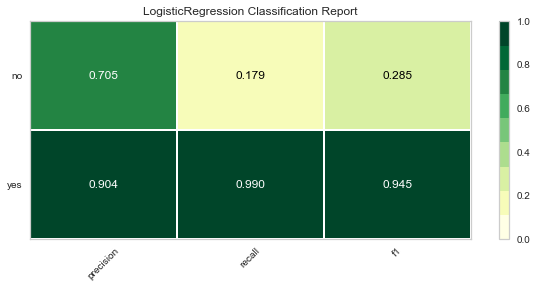

In [263]:
show_classification_rpt(logit)

## Decision Tree

In [76]:
tree = DecisionTreeClassifier(random_state=rand_state)

In [77]:
print("Accuracy with Decision Tree", end=': ')
dt_accuracy = fit_predict(tree, X_train, X_test, y_train, y_test)
print(dt_accuracy)

Accuracy with Decision Tree: 0.8549091968534525


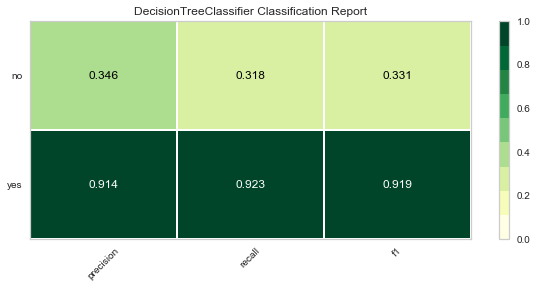

In [78]:
show_classification_rpt(tree)

### Hyper Parameter Tuning

In [79]:
def fit_predict_dt(train, test, y_train, y_test, scaler, max_depth,
               criterion = 'entropy', max_features=1, min_samples_split=4):
    train_scaled = scaler.fit_transform(train)
    test_scaled = scaler.transform(test)
    dt = DecisionTreeClassifier(criterion = criterion, max_depth=max_depth,
                               random_state= 101, max_features=max_features,
                               min_samples_split=min_samples_split)
    dt.fit(train_scaled, y_train)
    y_pred = dt.predict(test_scaled)
    return accuracy_score(y_test, y_pred)

### Max depth parameter tuning

In [80]:
list_max_depth = []

In [81]:
for i in range(1,30):
    print("Accuracy score using max_depth = ", i, end = ':')
    dt_max_depth = fit_predict_dt(X_train, X_test, y_train, y_test, StandardScaler(), i)
    print(dt_max_depth)
    list_max_depth.append(dt_max_depth)
    
max_depth_tuned = list_max_depth.index(max(list_max_depth))+1
print(max_depth_tuned)

Accuracy score using max_depth =  1:0.8868602505584151
Accuracy score using max_depth =  2:0.8868602505584151
Accuracy score using max_depth =  3:0.8868602505584151
Accuracy score using max_depth =  4:0.8865689035641449
Accuracy score using max_depth =  5:0.8868602505584151
Accuracy score using max_depth =  6:0.8867631348936583
Accuracy score using max_depth =  7:0.8869573662231718
Accuracy score using max_depth =  8:0.8872487132174419
Accuracy score using max_depth =  9:0.8871515975526852
Accuracy score using max_depth =  10:0.8902592988249004
Accuracy score using max_depth =  11:0.8931727687676022
Accuracy score using max_depth =  12:0.8889967951830631
Accuracy score using max_depth =  13:0.8897737205011168
Accuracy score using max_depth =  14:0.8928814217733321
Accuracy score using max_depth =  15:0.8887054481887928
Accuracy score using max_depth =  16:0.8882198698650092
Accuracy score using max_depth =  17:0.8836554336214432
Accuracy score using max_depth =  18:0.8859862095756046
A

### Max features tuning

In [82]:
dict_max_features = {}

In [83]:
for i in np.arange(0.1,1.0,0.1):
    print('Accuracy score using max features =', i, end = ":")
    dt_max_features = fit_predict_dt(X_train, X_test, y_train, y_test, StandardScaler(), max_depth=max_depth_tuned, max_features=i)
    print(dt_max_features)
    dict_max_features[i]=dt_max_features

max_feature_tuned = max(dict_max_features, key=dict_max_features.get)
print(max_feature_tuned)

Accuracy score using max features = 0.1:0.8964747013693308
Accuracy score using max features = 0.2:0.8934641157618723
Accuracy score using max features = 0.30000000000000004:0.8943381567446829
Accuracy score using max features = 0.4:0.8942410410799262
Accuracy score using max features = 0.5:0.8935612314266291
Accuracy score using max features = 0.6:0.8949208507332232
Accuracy score using max features = 0.7000000000000001:0.8921044964552782
Accuracy score using max features = 0.8:0.892201612120035
Accuracy score using max features = 0.9:0.8928814217733321
0.1


### Min samples split tuning

In [84]:
dict_min_samples_split = {}

In [85]:
for i in range(2,10):
    print('Accuracy score using min samples split=', i, end=":")
    dt_min_sample_split = fit_predict_dt(X_train, X_test, y_train, y_test, StandardScaler(), max_depth=max_depth_tuned, max_features=max_feature_tuned, min_samples_split=i)
    print(dt_min_sample_split)
    dict_min_samples_split[i] = dt_min_sample_split
    
min_sample_split_tuned = max(dict_min_samples_split, key=dict_min_samples_split.get)
print(min_sample_split_tuned)

Accuracy score using min samples split= 2:0.8942410410799262
Accuracy score using min samples split= 3:0.8948237350684666
Accuracy score using min samples split= 4:0.8964747013693308
Accuracy score using min samples split= 5:0.8949208507332232
Accuracy score using min samples split= 6:0.8943381567446829
Accuracy score using min samples split= 7:0.8931727687676022
Accuracy score using min samples split= 8:0.8924929591143052
Accuracy score using min samples split= 9:0.8963775857045742
4


### Criterion tuning

In [86]:
dict_index_tuned = {}

In [87]:
for i in ['gini','entropy']:
    print("Accuracy score using criterion: ", i, end = ':')
    dt_index_score = fit_predict_dt(X_train, X_test, y_train, y_test, StandardScaler(), max_depth=max_depth_tuned, max_features = max_feature_tuned, min_samples_split=min_sample_split_tuned, criterion= i)
    print(dt_index_score)
    dict_index_tuned[i] = dt_index_score

dt_index_tuned = max(dict_index_tuned, key=dict_index_tuned.get)
print(dt_index_tuned)

Accuracy score using criterion:  gini:0.8935612314266291
Accuracy score using criterion:  entropy:0.8964747013693308
entropy


### Rerunning decision tree with best parameters

In [88]:
dt_best_param_score  =  fit_predict_dt(X_train, X_test, y_train, y_test, StandardScaler(), max_depth=max_depth_tuned, max_features = max_feature_tuned, min_samples_split=min_sample_split_tuned, criterion= dt_index_tuned)
print("Accuracy score for decision tree using best param: ", end = ':')
print(dt_best_param_score)

Accuracy score for decision tree using best param: :0.8964747013693308


In [92]:
tree1 = DecisionTreeClassifier(criterion = dt_index_tuned, max_depth=max_depth_tuned,
                               random_state= rand_state, max_features=max_feature_tuned,
                               min_samples_split=min_sample_split_tuned)

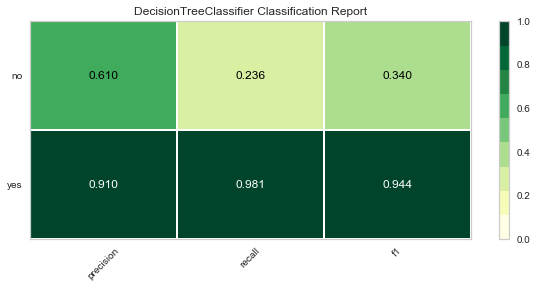

In [93]:
show_classification_rpt(tree1)

### Using polynomial features

In [94]:
def create_poly(train, test, degree):
    poly = PolynomialFeatures(degree = degree)
    train_poly = poly.fit_transform(train)
    test_poly = poly.fit_transform(test)
    return train_poly, test_poly

In [264]:
## polynomial features taking a lot of time as the number of columns are more. Hence commented the following piece of code

In [95]:
# for degree in [1,2,3,4]:
#     train_poly, test_poly = create_poly(X_train, X_test, degree)
#     print("polynomial degree", degree)
#     fit_predict(train_poly, test_poly, y_train, y_test, StandardScaler(), 16, max_features = 0.2,min_samples_split=4, criterion='entropy')
#     print(10 *'-')

## Random Forest

In [96]:
forest = RandomForestClassifier(criterion='entropy', oob_score=True)

In [97]:
print("Accuracy with Random Forest", end=': ')
rf_accuracy = fit_predict(forest, X_train, X_test, y_train, y_test)
print(rf_accuracy)

Accuracy with Random Forest: 0.8869573662231718


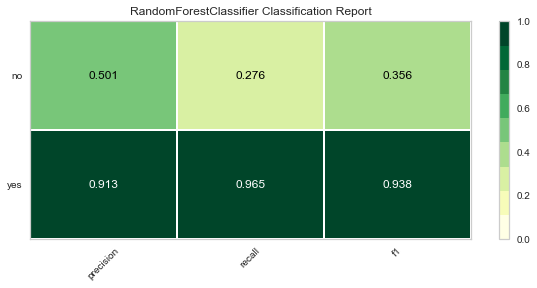

In [98]:
show_classification_rpt(forest)

### Parameter tuning using Grid Search

In [99]:
from sklearn.model_selection import GridSearchCV

In [100]:
params = {
    'n_estimators': [200,500,700],
    'max_depth': [10,15,20,25,30],
    'min_samples_leaf': [3,5,7]
}

In [101]:
gs = GridSearchCV(forest, params, cv=cv, verbose=verbose, n_jobs=number_of_jobs)

In [187]:
if grid_search_enable == True:
    gs.fit(X_train, y_train)

Fitting 2 folds for each of 45 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  9.0min finished


In [188]:
if grid_search_enable == True:
    print(gs.best_params_)

{'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 700}


In [189]:
if grid_search_enable == True:
    forest_best_max_depth = gs.best_params_['max_depth']
    forest_best_min_samples = gs.best_params_['min_samples_leaf']
    forest_best_n_estimators = gs.best_params_['n_estimators']
    #forest_best_criterion = gs.best_params_['criterion']

In [190]:
if grid_search_enable == True:
    print(gs.best_estimator_)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=700,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)


### Retraining with best estimators

In [191]:
if grid_search_enable == True:
    forest1 = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=forest_best_max_depth, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=forest_best_min_samples, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=forest_best_n_estimators,
                       n_jobs=number_of_jobs, oob_score=True, random_state=rand_state,
                       verbose=0, warm_start=False)

In [192]:
if grid_search_enable == True:
    forest1.fit(X_train, y_train)

In [193]:
if grid_search_enable == True:
    pred_forest1 = forest1.predict(X_test)

In [194]:
if grid_search_enable == True:
    print("Accuracy with Random Forest after Hyper Parameter Tuning", end=': ')
    rf_hyper_accuracy = accuracy_score(y_test, pred_forest1)
    print(rf_hyper_accuracy)

Accuracy with Random Forest after Hyper Parameter Tuning: 0.8996795183063028


In [195]:
if grid_search_enable == True:
    for x in sorted(list(zip(forest1.feature_importances_, X_train.columns)), reverse=True):
        print(x)

(0.14179948769158793, 'f.euribor_lt_1')
(0.13243410432625283, 'f.euribor_gt_4')
(0.09140105269693241, 'cons.price.idx')
(0.0875839544871553, 'pdays')
(0.035722252096226446, 'poutcome_success')
(0.03053642864299725, 'poutcome_failure')
(0.028317015336440387, 'f.euribor_gt_1_lt_2')
(0.028243417664337574, 'f.previous_new user')
(0.026945702929547156, 'contact_telephone')
(0.026561653023166158, 'f.previous_existing user')
(0.024848009118038767, 'contact_cellular')
(0.023640002768234216, 'month_may')
(0.020591305695899537, 'f.age_weightage')
(0.01622358572039929, 'f.seasons_spring')
(0.015863565076978437, 'campaign')
(0.015533093136756755, 'f.season_weight')
(0.014875667079553704, 'month_oct')
(0.012347943427545102, 'month_mar')
(0.011101082066328056, 'f.festivals')
(0.010640818731409776, 'f.seasons_summer')
(0.00843848524709509, 'f.salary')
(0.007598308757690786, 'month_apr')
(0.00732561057280064, 'f.retired_status_retired')
(0.00676766195929507, 'month_jun')
(0.006369723247777698, 'f.seas

In [196]:
### Confusion matrix
from sklearn.metrics import confusion_matrix, classification_report

In [197]:
if grid_search_enable == True:
    print(confusion_matrix(y_test, pred_forest1))

[[9035   97]
 [ 936  229]]


## Accuracy Summary

In [198]:
print("Accuracy with Logistic Regression", end=': ')
print(logit_accuracy)
print("Accuracy with Decision Tree", end=': ')
print(dt_accuracy)
print("Accuracy of Decision Tree after Hyper Parameter Tuning: ", end = ':')
print(dt_best_param_score)
print("Accuracy with Random Forest", end=': ')
print(rf_accuracy)
if grid_search_enable == True:
    print("Accuracy with Random Forest after Hyper Parameter Tuning", end=': ')
    print(rf_hyper_accuracy)

Accuracy with Logistic Regression: 0.8986112459939788
Accuracy with Decision Tree: 0.8549091968534525
Accuracy of Decision Tree after Hyper Parameter Tuning: :0.8969602796931145
Accuracy with Random Forest: 0.8869573662231718
Accuracy with Random Forest after Hyper Parameter Tuning: 0.8996795183063028


In [199]:
# todo -- for rows where there are no patterns but td = yes, check if any patterns emerge and record it and re-run the models
# todo -- try adaboost algorithm

## AdaBoost

In [200]:
from sklearn.ensemble import AdaBoostClassifier

In [201]:
adabst_fit = AdaBoostClassifier(base_estimator=logit, random_state=rand_state, n_estimators=100)

In [202]:
adabst_fit.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=LogisticRegression(C=1.0, class_weight=None,
                                                     dual=False,
                                                     fit_intercept=True,
                                                     intercept_scaling=1,
                                                     l1_ratio=None,
                                                     max_iter=100,
                                                     multi_class='auto',
                                                     n_jobs=None, penalty='l2',
                                                     random_state=None,
                                                     solver='lbfgs', tol=0.0001,
                                                     verbose=0,
                                                     warm_start=False),
                   learning_rate=1.0, n_estimators=100, random_state=101)

In [203]:
print("Accuracy with Ada Boost", end=': ')
ada_boost_predict = adabst_fit.predict(X_test)
ada_boost_accuracy = accuracy_score(y_test,ada_boost_predict)
print(ada_boost_accuracy)

Accuracy with Ada Boost: 0.899291055647276


In [204]:
print(confusion_matrix(y_test, adabst_fit.predict(X_test)))

[[9033   99]
 [ 938  227]]


### Adaboost with Grid Search

In [205]:
params_adaboost = {
    'n_estimators': [100,200,300],
    'base_estimator': [logit, tree1],
    'learning_rate': [0.5,0.75,1.0]
}

In [206]:
ada_gs = GridSearchCV(adabst_fit, params_adaboost, cv=cv, n_jobs=number_of_jobs)

In [207]:
if grid_search_enable == True:
    ada_gs.fit(X_train, y_train)

In [208]:
if grid_search_enable == True:
    adabst_best_estimator = ada_gs.best_params_['base_estimator']
    adabst_best_learning_rate = ada_gs.best_params_['learning_rate']
    adabst_best_n_estimators = ada_gs.best_params_['n_estimators']

In [209]:
if grid_search_enable == True:
    ada_gs.best_params_

### Adaboost - Retraining with best estimators

In [210]:
if grid_search_enable == True:
    ada_best = AdaBoostClassifier(base_estimator=adabst_best_estimator, random_state=rand_state,
                                  n_estimators=adabst_best_n_estimators, learning_rate=adabst_best_learning_rate)

In [211]:
if grid_search_enable == True:
    ada_best.fit(X_train, y_train)
    ada_best_predict = ada_best.predict(X_test)

In [212]:
if grid_search_enable == True:
    print("Accuracy with Adaboost after Hyper Parameter Tuning", end=': ')
    ada_best_hyper_accuracy = accuracy_score(y_test, ada_best_predict)
    print(ada_best_hyper_accuracy)

Accuracy with Adaboost after Hyper Parameter Tuning: 0.8996795183063028


## Gradient Boost

In [213]:
from sklearn.ensemble import GradientBoostingClassifier

In [214]:
gbc_fit = GradientBoostingClassifier(n_estimators=500,
                                     min_samples_split=2,min_samples_leaf=1,max_depth=1,random_state=rand_state)

In [215]:
gbc_fit.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=1,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=500,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=101, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [216]:
print("Accuracy with Gradient Boost", end=': ')
gbc_accuracy = accuracy_score(y_test,gbc_fit.predict(X_test))
print(gbc_accuracy)

Accuracy with Gradient Boost: 0.8981256676701952


### Gradient boost with Grid Search

In [217]:
params_gbc = {
    'n_estimators': [100,300,500],
    'max_depth': [2,3,4],
    'learning_rate': [0.05,0.075,0.1]
}

In [218]:
gbc_gs = GridSearchCV(gbc_fit, params_gbc, cv=cv, n_jobs=number_of_jobs)

In [219]:
if grid_search_enable == True:
    gbc_gs.fit(X_train, y_train)

In [220]:
if grid_search_enable == True:
    gbc_best_estimator = gbc_gs.best_params_['n_estimators']
    gbc_best_max_depth = gbc_gs.best_params_['max_depth']
    gbc_best_learning_rate = gbc_gs.best_params_['learning_rate']

In [221]:
if grid_search_enable == True:
    print(gbc_gs.best_params_)

{'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 100}


### Gradient Boost - With Best Parameters

In [222]:
if grid_search_enable == True:
    gbc_best = GradientBoostingClassifier(n_estimators=gbc_best_estimator,
                                     min_samples_split=2,min_samples_leaf=1,max_depth=gbc_best_max_depth,random_state=rand_state,
                                         learning_rate=gbc_best_learning_rate)

In [223]:
if grid_search_enable == True:
    gbc_best.fit(X_train, y_train)
    gbc_best_predict = gbc_best.predict(X_test)

In [224]:
if grid_search_enable == True:
    print("Accuracy with Gradient Boost after Hyper Parameter Tuning", end=': ')
    gbc_best_hyper_accuracy = accuracy_score(y_test, gbc_best_predict)
    print(gbc_best_hyper_accuracy)

Accuracy with Gradient Boost after Hyper Parameter Tuning: 0.8994852869767893


## XG Boost

In [225]:
from xgboost import XGBClassifier

In [226]:
xgb_fit = XGBClassifier(max_depth=2, n_estimators=5000, random_state=rand_state, n_jobs=number_of_jobs)
xgb_fit.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=None, n_estimators=5000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=101,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [227]:
print("Accuracy with XG Boost", end=': ')
xgb_predict = xgb_fit.predict(X_test)
xgb_accuracy = accuracy_score(y_test,xgb_predict)
print(xgb_accuracy)

Accuracy with XG Boost: 0.8994852869767893


### XG Boost with Grid Search

In [228]:
xgb_params = {
    'max_depth': [2,3,4],
    'n_estimators': [300,500,700],
    'learning_rate': [0.05,0.075,0.1]
}

In [229]:
xgb_gs = GridSearchCV(xgb_fit, xgb_params, cv=cv, n_jobs=number_of_jobs)

In [230]:
if grid_search_enable == True:
    xgb_gs.fit(X_train, y_train)

In [231]:
if grid_search_enable == True:
    print(xgb_gs.best_params_)

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 500}


In [232]:
if grid_search_enable == True:
    xgb_best_max_depth = xgb_gs.best_params_['max_depth']
    xgb_best_n_estimators = xgb_gs.best_params_['n_estimators']
    xgb_best_learning_rate = xgb_gs.best_params_['learning_rate']

### Re-running XG Boost with Best Parameters

In [233]:
if grid_search_enable == True:
    xgb_best = XGBClassifier(max_depth=xgb_best_max_depth,
                             n_estimators=xgb_best_n_estimators, random_state=rand_state,
                             n_jobs=number_of_jobs, learning_rate = xgb_best_learning_rate)
    xgb_best.fit(X_train, y_train)
    xgb_best_predict = xgb_best.predict(X_test)

In [234]:
if grid_search_enable == True:
    print("Accuracy with XG Boost after Hyper Parameter Tuning", end=': ')
    xgb_best_hyper_accuracy = accuracy_score(y_test, xgb_best_predict)
    print(xgb_best_hyper_accuracy)

Accuracy with XG Boost after Hyper Parameter Tuning: 0.8995824026415461


## Accuracy Summary

In [235]:
print("Accuracy with Logistic Regression", end=': ')
print(logit_accuracy)

print("Accuracy with Decision Tree", end=': ')
print(dt_accuracy)
print("Accuracy with Decision Tree after Hyper Parameter Tuning: ", end = ':')
print(dt_best_param_score)

print("Accuracy with Random Forest", end=': ')
print(rf_accuracy)
if grid_search_enable == True:
    print("Accuracy with Random Forest after Hyper Parameter Tuning", end=': ')
    print(rf_hyper_accuracy)

print("Accuracy with Ada Boost", end=': ')
print(ada_boost_accuracy)
if grid_search_enable == True:
    print("Accuracy with Ada Boost after Hyper Parameter Tuning", end=': ')
    print(ada_best_hyper_accuracy)

print("Accuracy with Gradient Boost", end=': ')
print(gbc_accuracy)
if grid_search_enable == True:
    print("Accuracy with Gradient Boost after Hyper Parameter Tuning", end=': ')
    print(gbc_best_hyper_accuracy)
    
print("Accuracy with XG Boost", end=': ')
print(xgb_accuracy)
if grid_search_enable == True:
    print("Accuracy with XG Boost after Hyper Parameter Tuning", end=': ')
    print(xgb_best_hyper_accuracy)

Accuracy with Logistic Regression: 0.8986112459939788
Accuracy with Decision Tree: 0.8549091968534525
Accuracy with Decision Tree after Hyper Parameter Tuning: :0.8969602796931145
Accuracy with Random Forest: 0.8869573662231718
Accuracy with Random Forest after Hyper Parameter Tuning: 0.8996795183063028
Accuracy with Ada Boost: 0.899291055647276
Accuracy with Ada Boost after Hyper Parameter Tuning: 0.8996795183063028
Accuracy with Gradient Boost: 0.8981256676701952
Accuracy with Gradient Boost after Hyper Parameter Tuning: 0.8994852869767893
Accuracy with XG Boost: 0.8994852869767893
Accuracy with XG Boost after Hyper Parameter Tuning: 0.8995824026415461
